In [1]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

In [2]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [3]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# im = Image.open("./attention_data/img.jpg")
im = Image.open("./attention_data/img.jpg")
x = transform(im)
x.size()

torch.Size([3, 224, 224])

In [4]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))

Prediction Label and Attention Map!

0.95246 : white_stork, Ciconia_ciconia
0.04349 : black_stork, Ciconia_nigra
0.00070 : crane
0.00025 : goose
0.00020 : pelican


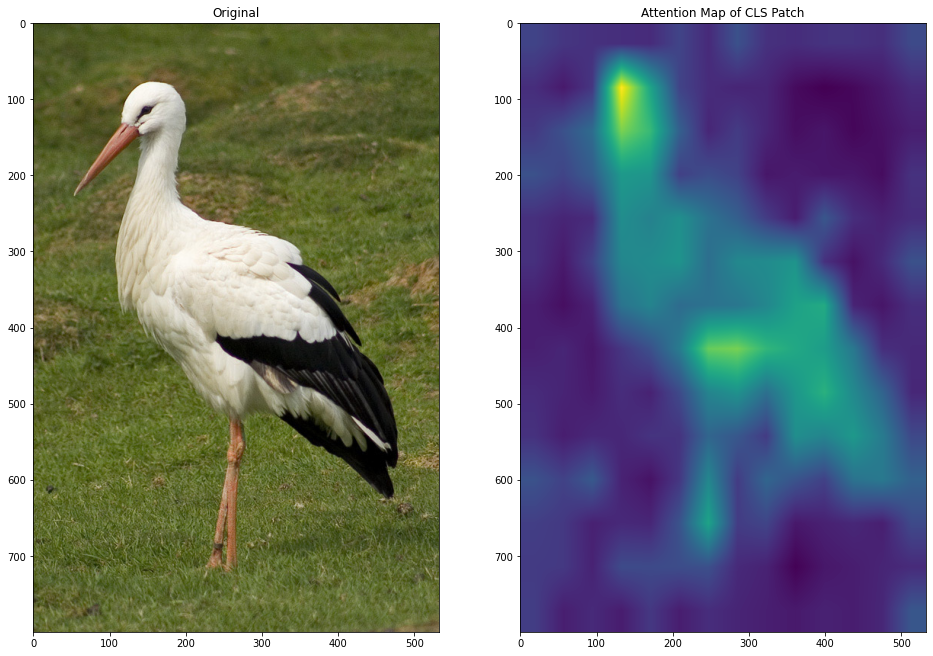

In [5]:
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Mask of CLS Patch')
ax2.set_title('Attention Map of CLS Patch')
_ = ax1.imshow(im)
_ = ax2.imshow(mask)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

In [6]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))

avg_v = torch.mean(v, dim = 0)

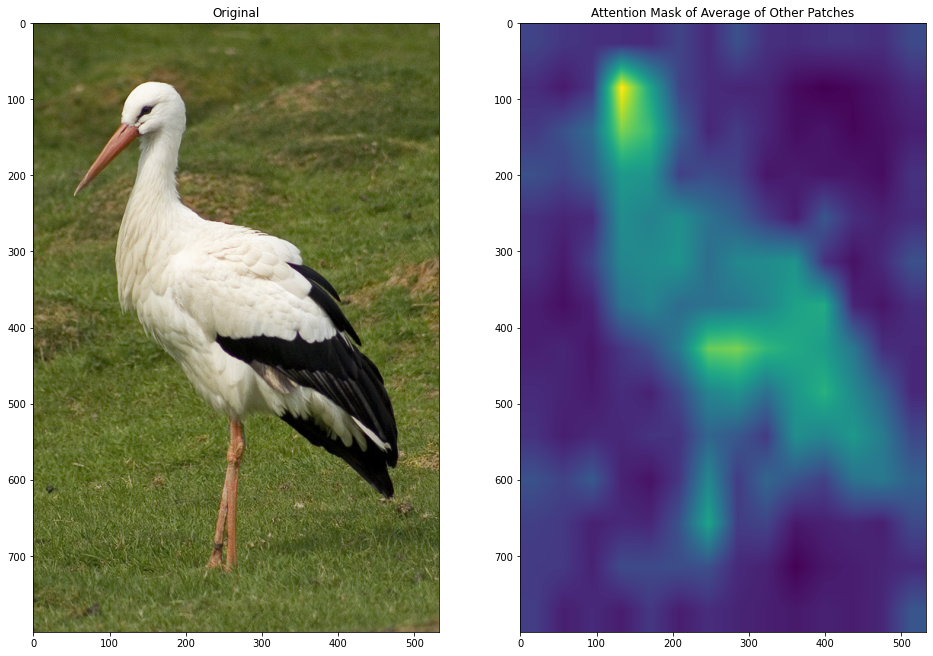

In [7]:
new_mask = avg_v[1:].reshape(grid_size, grid_size).detach().numpy()
new_mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Mask of Average of Other Patches')
_ = ax1.imshow(im)
_ = ax2.imshow(new_mask)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Predict labels using CLS patch:
0.95246 : white_stork, Ciconia_ciconia
0.04349 : black_stork, Ciconia_nigra
0.00070 : crane
0.00025 : goose
0.00020 : pelican
Predict labels using average of other patches:
0.92540 : white_stork, Ciconia_ciconia
0.06173 : black_stork, Ciconia_nigra
0.00167 : crane
0.00048 : pelican
0.00036 : flamingo


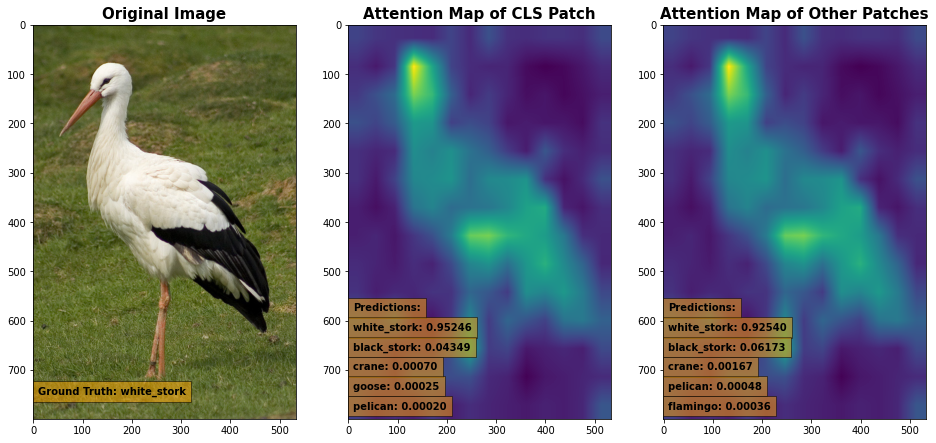

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))
ax1.set_title('Original Image', fontsize = 15, fontname="Times New Roman", fontweight="bold")
ax2.set_title('Attention Map of CLS Patch', fontsize = 15, fontname="Times New Roman", fontweight="bold")
ax3.set_title('Attention Map of Other Patches', fontsize = 15, fontname="Times New Roman", fontweight="bold")

_ = ax1.imshow(im)
_ = ax2.imshow(mask)
_ = ax3.imshow(new_mask)

ax1.annotate('Ground Truth: white_stork', xy = (10, 750), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

ax2.annotate('Predictions:', xy = (10, 580), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax2.annotate('white_stork: 0.95246', xy = (10, 620), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax2.annotate('black_stork: 0.04349', xy = (10, 660), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax2.annotate('crane: 0.00070', xy = (10, 700), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax2.annotate('goose: 0.00025', xy = (10, 740), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax2.annotate('pelican: 0.00020', xy = (10, 780), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

ax3.annotate('Predictions:', xy = (10, 580), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax3.annotate('white_stork: 0.92540', xy = (10, 620), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax3.annotate('black_stork: 0.06173', xy = (10, 660), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax3.annotate('crane: 0.00167', xy = (10, 700), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax3.annotate('pelican: 0.00048', xy = (10, 740), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
ax3.annotate('flamingo: 0.00036', xy = (10, 780), 
             fontsize=10, fontweight="bold", bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

plt.savefig('illustration.pdf',bbox_inches='tight')  

h = model.transformer(x.unsqueeze(0))[0]
logits = model.head(h[:,0])
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Predict labels using CLS patch:")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')
    
h = model.transformer(x.unsqueeze(0))[0]
avg_h = torch.mean(h[:,1:,:], dim = 1)
logits = model.head(avg_h)
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Predict labels using average of other patches:")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

In [9]:
h = model.transformer(x.unsqueeze(0))[0]
logits = model.head(h[:,0])
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Predict labels using CLS patch:")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

Predict labels using CLS patch:
0.95246 : white_stork, Ciconia_ciconia
0.04349 : black_stork, Ciconia_nigra
0.00070 : crane
0.00025 : goose
0.00020 : pelican


In [10]:
h = model.transformer(x.unsqueeze(0))[0]
avg_h = torch.mean(h[:,1:,:], dim = 1)
logits = model.head(avg_h)
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Predict labels using average of other patches:")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

Predict labels using average of other patches:
0.92540 : white_stork, Ciconia_ciconia
0.06173 : black_stork, Ciconia_nigra
0.00167 : crane
0.00048 : pelican
0.00036 : flamingo


Predict labels using CLS patch:
0.95246 : white_stork, Ciconia_ciconia
0.04349 : black_stork, Ciconia_nigra
0.00070 : crane
0.00025 : goose
0.00020 : pelican
Predict labels using average of other patches:
0.92540 : white_stork, Ciconia_ciconia
0.06173 : black_stork, Ciconia_nigra
0.00167 : crane
0.00048 : pelican
0.00036 : flamingo


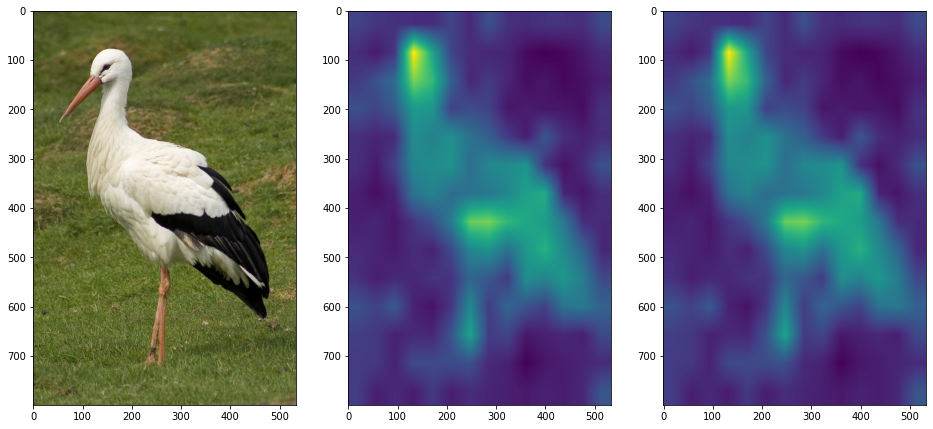

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))
# ax1.set_title('Original Image', fontsize = 15, fontname="Times New Roman", fontweight="bold")
# ax2.set_title('Attention Map of CLS Patch', fontsize = 15, fontname="Times New Roman", fontweight="bold")
# ax3.set_title('Attention Map of Other Patches', fontsize = 15, fontname="Times New Roman", fontweight="bold")

_ = ax1.imshow(im)
_ = ax2.imshow(mask)
_ = ax3.imshow(new_mask)

plt.savefig('illustration.pdf',bbox_inches='tight')  

h = model.transformer(x.unsqueeze(0))[0]
logits = model.head(h[:,0])
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Predict labels using CLS patch:")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')
    
h = model.transformer(x.unsqueeze(0))[0]
avg_h = torch.mean(h[:,1:,:], dim = 1)
logits = model.head(avg_h)
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Predict labels using average of other patches:")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

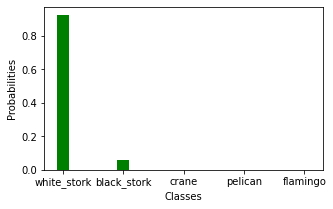

In [65]:
import numpy as np
import matplotlib.pyplot as plt
marks=[0.92540,0.06173,0.00167,0.00048,0.00036]
bars=('white_stork','black_stork','crane','pelican', 'flamingo')
y=np.arange(len(bars))


plt.figure(figsize=(5, 3))

plt.bar(y,marks,color='g', width = 0.2)
plt.xticks(y,bars)
plt.xlabel('Classes')
plt.ylabel('Probabilities')


plt.show()

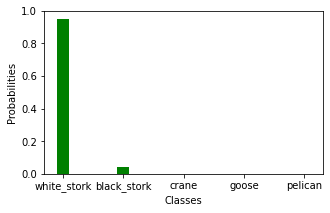

In [66]:
import numpy as np
import matplotlib.pyplot as plt
marks=[0.95246,0.04349,0.00070,0.00025,0.00036]
bars=('white_stork','black_stork','crane','goose', 'pelican')
y=np.arange(len(bars))


plt.figure(figsize=(5, 3))

plt.bar(y,marks,color='g', width = 0.2)
plt.xticks(y,bars)
plt.xlabel('Classes')
plt.ylabel('Probabilities')


plt.show()

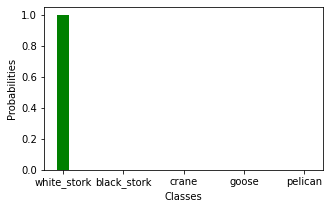

In [67]:
import numpy as np
import matplotlib.pyplot as plt
marks=[1.00000,0.00000,0.00000,0.00000,0.00000]
bars=('white_stork','black_stork','crane','goose', 'pelican')
y=np.arange(len(bars))


plt.figure(figsize=(5, 3))

plt.bar(y,marks,color='g', width = 0.2)
plt.xticks(y,bars)
plt.xlabel('Classes')
plt.ylabel('Probabilities')


plt.show()